In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression

from causalml.inference.meta import (
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
    BaseRClassifier,
)

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier


---
### В данной домашней работе отрабатывается построение uplift-моделей на примере использования s-learner'a, t-learner'a, X-learner'a, R-learner'a, uplift_tree и uplift_rf. 
### Исходя из структуры данных (закодированные и скорее всего нормализованные фиты) мы будем по-сути сравнивать работу base-line моделей каждого вида классификаторов, для базовых моделей были выбраны логистическая и линейная регрессии, как менее склонные к переобучению.

---
#### Структура данных

In [2]:
data = pd.read_csv("./data/criteo.csv")
data.head()
print(data.shape)

(13979592, 16)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


---
A more detailed description of the features is shown below:

f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)

treatment: treatment group (1 = treated, 0 = control)

conversion: whether a conversion occured for this user (binary, label)

visit: whether a visit occured for this user (binary, label)

exposure: treatment effect, whether the user has been effectively exposed (binary)

---

In [5]:
data["conversion"].value_counts()

0    13938818
1       40774
Name: conversion, dtype: int64

In [6]:
data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
# Удалим дубликаты
data = data[~data.duplicated()]
print(data.shape)

(12720047, 16)


In [8]:
data.isna().value_counts()

f0     f1     f2     f3     f4     f5     f6     f7     f8     f9     f10    f11    treatment  conversion  visit  exposure
False  False  False  False  False  False  False  False  False  False  False  False  False      False       False  False       12720047
dtype: int64

---
#### Предподготовка

In [9]:
# Выделим в три переменные наименования фитов, сформировав treatment_col, target_col и feature_cols
treatment_col = "treatment"
target_col = "conversion"

feature_cols = [
    i for i in data.columns.to_list() if i not in [treatment_col, target_col, "exposure"]
]

scaling_cols = [i for i in feature_cols if i not in ["visit", "exposure"]]

In [10]:
scaler = StandardScaler()
data[scaling_cols] = scaler.fit_transform(data[scaling_cols])
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,-1.253594,-0.103344,1.706354,0.392952,-0.177639,0.211813,0.992511,-0.233596,0.433143,-0.424646,-0.205215,0.104938,1,0,0,0
1,-1.253594,-0.103344,1.793295,0.392952,-0.177639,0.211813,0.992511,-0.233596,0.433143,-0.424646,-0.205215,0.104938,1,0,0,0
2,-1.253594,-0.103344,1.667772,0.392952,-0.177639,0.211813,0.992511,-0.233596,0.433143,-0.424646,-0.205215,0.104938,1,0,0,0
3,-1.253594,-0.103344,1.793664,0.392952,-0.177639,0.211813,0.992511,-0.233596,0.433143,-0.424646,-0.205215,0.104938,1,0,0,0
4,-1.253594,-0.103344,1.910194,0.392952,-0.177639,0.211813,0.992511,-0.233596,0.433143,-0.424646,-0.205215,0.104938,1,0,0,0


---
#### Для дальнейшей работы было принято решение сэмплировать данные для возможности реализации алгоритмов

In [32]:
# Сэмплируем
data_main, data_work = train_test_split(
    data,
    stratify=data[[target_col, treatment_col]],
    test_size=0.2,
    random_state=42
)

# Построим тренировочный и валидационный датасеты на основе сэмпла. 
data_train, data_test = train_test_split(
    data_work,
    stratify=data_work[[target_col, treatment_col]],
    test_size=0.2,
    random_state=42
)

print(data_train.shape)
print(data_test.shape)

data_train.head()

(2035208, 16)
(508802, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
5645708,-1.253594,-0.103344,0.818884,0.392952,-0.177639,0.211813,0.992511,-0.233596,0.433143,-0.424646,-0.205215,0.104938,0,0,0,0
6881818,-1.253594,-0.103344,0.777643,0.392952,-0.177639,0.211813,0.992511,-0.233596,-1.679046,-0.424646,-0.205215,0.104938,1,0,0,0
4794375,0.860513,-0.103344,-0.816560,0.392952,-0.177639,0.211813,-1.424925,-0.233596,0.715928,-0.424646,-0.205215,0.104938,1,0,0,0
7955612,-1.253594,-0.103344,-0.792803,0.392952,-0.177639,0.211813,0.992511,-0.233596,-2.072546,1.770695,-0.205215,0.104938,1,0,0,0
615107,-1.226467,-0.103344,1.316309,-4.513826,-0.177639,0.211813,-2.152133,-0.233596,-0.589527,-0.424646,-0.205215,0.104938,1,0,0,0


#### В целом такой подход (эмпирически) показал сохранение геометрии qini-curve (т.е. прогностическая способность глобально та же) с ухудшением (пропорционально уменьшению объема данных) qini-score, что оставляет возможность для анализа и выявления оптимального подхода при составлении uplift модели.

In [16]:
# Создадим функцию для подсчета qini-score и отрисовки qini-curve
def qini_df(df, title="train", figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked["exposure"] == 0)
    N_t = sum(ranked["exposure"] == 1)

    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked["n_c1"] = 0
    ranked["n_t1"] = 0
    ranked.loc[ranked.exposure == 0, "n_c1"] = 0
    ranked.loc[ranked.exposure == 1, "n_t1"] = 1
    ranked["n_c1/nc"] = ranked.n_c1.cumsum() / N_c
    ranked["n_t1/nt"] = ranked.n_t1.cumsum() / N_t

    # Посчитаем qini curve и рандомную прямую под ней
    ranked["uplift"] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # Добавим случайную кривую
    ranked["random_uplift"] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )
    
    # Создания фита для отрисовки в 2 измерениях
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)

    # Визуализация
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked["n"], ranked["uplift"], color="r", label="Model")
    plt.plot(ranked["n"], ranked["random_uplift"], color="b", label="RandomModel")
    plt.legend()
    plt.title("Qini-curve for {} samples".format(title))
    plt.show()
    quni_score = (ranked["uplift"] - ranked["random_uplift"]).sum()
    print("Qini score: {:.3f}".format(quni_score))

---
#### S-learner

In [30]:
s_learner = BaseSClassifier(
    learner=LogisticRegression(
        random_state=42, solver="saga", max_iter=10000, n_jobs=-1
    )
)

s_learner.fit(
    X=data_train[feature_cols],
    treatment=data_train[treatment_col],
    y=data_train[target_col],
)

uplift_vals_train = s_learner.predict(np.array(data_train[feature_cols].values.copy()))
data_train["uplift_score"] = uplift_vals_train

uplift_vals_test = s_learner.predict(np.array(data_test[feature_cols].values.copy()))
data_test["uplift_score"] = uplift_vals_test

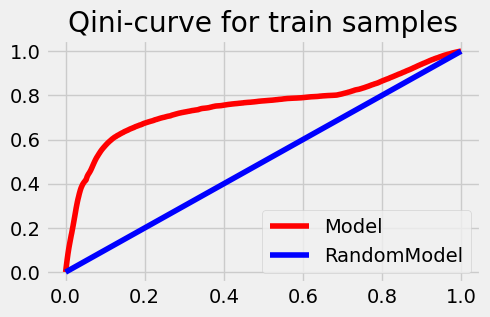

Qini score: 510634.748


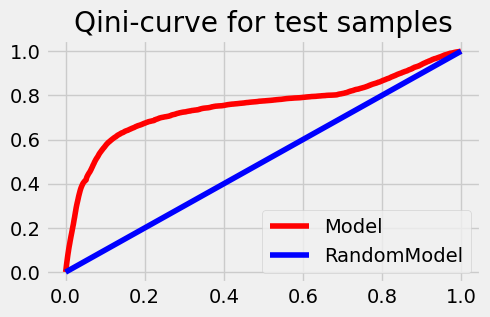

Qini score: 127768.503


In [31]:
# Посмотрим на скоры на трейне и валидации
qini_df(data_train, title="train")
qini_df(data_test, title="test")

> Вывод

---
#### T-learner

In [34]:
t_learner = BaseTClassifier(
    learner=LogisticRegression(
        random_state=42, solver="saga", max_iter=10000, n_jobs=-1
    )
)

t_learner.fit(
    X=data_train[feature_cols],
    treatment=data_train[treatment_col],
    y=data_train[target_col],
)

uplift_vals_train = t_learner.predict(np.array(data_train[feature_cols].values.copy()))
data_train["uplift_score"] = uplift_vals_train

uplift_vals_test = t_learner.predict(np.array(data_test[feature_cols].values.copy()))
data_test["uplift_score"] = uplift_vals_test

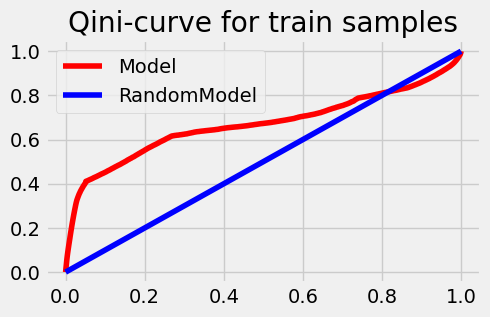

Qini score: 343513.032


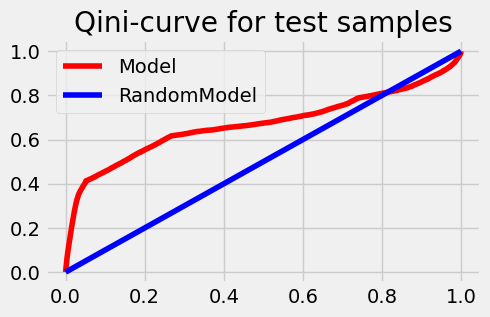

Qini score: 86516.330


In [35]:
# Посмотрим на скоры на трейне и валидации
qini_df(data_train, title="train")
qini_df(data_test, title="test")

> Вывод

---
#### X-learner

In [20]:
# ваш код здесь
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(
        random_state=42, solver="saga", max_iter=10000, n_jobs=-1
    ),
    effect_learner=LinearRegression(),
)

x_learner.fit(
    X=data_train[feature_cols],
    treatment=data_train[treatment_col],
    y=data_train[target_col],
)

uplift_vals_train = x_learner.predict(np.array(data_train[feature_cols].values.copy()))
data_train["uplift_score"] = uplift_vals_train

uplift_vals_test = x_learner.predict(np.array(data_test[feature_cols].values.copy()))
data_test["uplift_score"] = uplift_vals_test

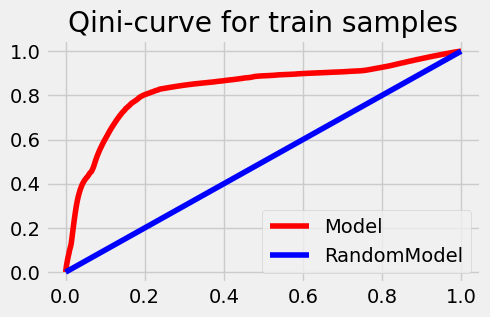

Qini score: 3363305.504


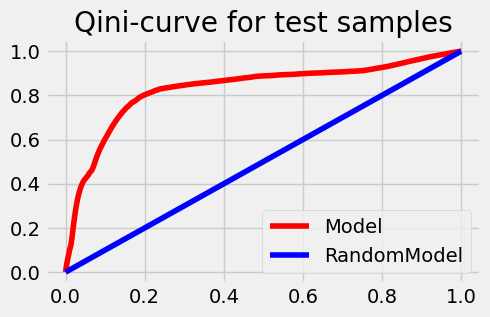

Qini score: 841470.319


In [21]:
# Посмотрим на скоры на трейне и валидации
qini_df(data_train, title="train")
qini_df(data_test, title="test")

> Вывод

---
#### R-learner

In [24]:
# ваш код здесь
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(
        random_state=42, solver="saga", max_iter=10000, n_jobs=-1
    ),
    effect_learner=LinearRegression(),
    random_state=42,
)

r_learner.fit(
    X=data_train[feature_cols],
    treatment=data_train[treatment_col],
    y=data_train[target_col],
)

uplift_vals_train = r_learner.predict(np.array(data_train[feature_cols].values.copy()))
data_train["uplift_score"] = uplift_vals_train

uplift_vals_test = r_learner.predict(np.array(data_test[feature_cols].values.copy()))
data_test["uplift_score"] = uplift_vals_test

python(68774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68778) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


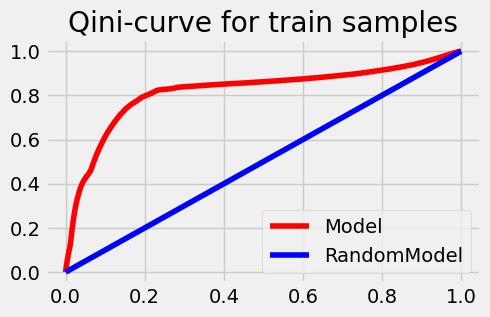

Qini score: 650236.423


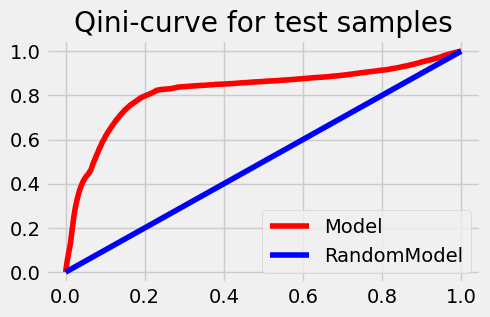

Qini score: 162772.415


In [25]:
# Посмотрим на скоры на трейне и валидации
qini_df(data_train, title="train")
qini_df(data_test, title="test")

> Вывод

---
#### Uplift_tree

In [26]:
# Создаем простое дерево.
uplift_tree = UpliftTreeClassifier(
    max_depth=5,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction="ED",
    control_name="0",
    random_state=42,
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_tree.fit(
    data_train[feature_cols].values,
    treatment=data_train[treatment_col].apply(str).values,
    y=data_train[target_col].values,
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(data_train[feature_cols].values.copy()))[
    :, 1
]
data_train["uplift_score"] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(data_test[feature_cols].values.copy()))[:, 1]
data_test["uplift_score"] = uplift_vals

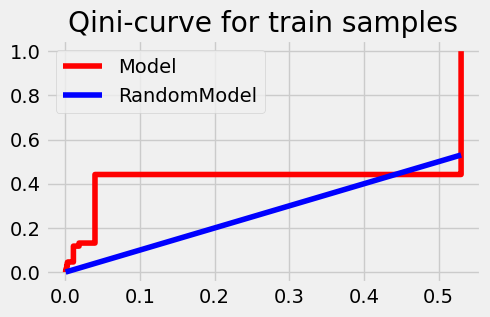

Qini score: 390943.584


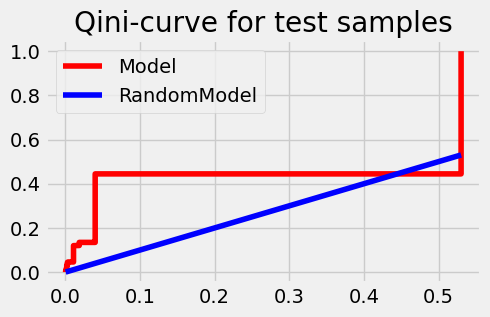

Qini score: 98707.906


In [27]:
# Посмотрим на скоры на трейне и валидации
qini_df(data_train, title="train")
qini_df(data_test, title="test")

> Вывод

---
#### Uplift_random_forst

In [28]:
# Создаем лес.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=100,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction="ED",
    control_name="0",
    random_state=42,
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    data_train[feature_cols].values,
    treatment=data_train[treatment_col].apply(str).values,
    y=data_train[target_col].values,
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(data_train[feature_cols].values.copy()))
data_train["uplift_score"] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(data_test[feature_cols].values.copy()))
data_test["uplift_score"] = uplift_vals

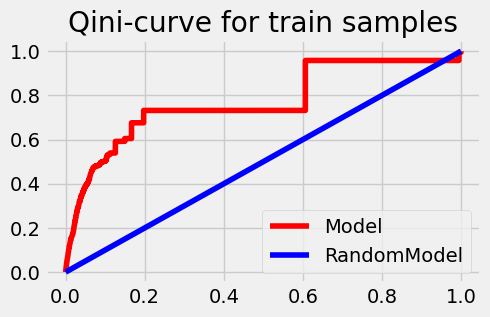

Qini score: 551353.561


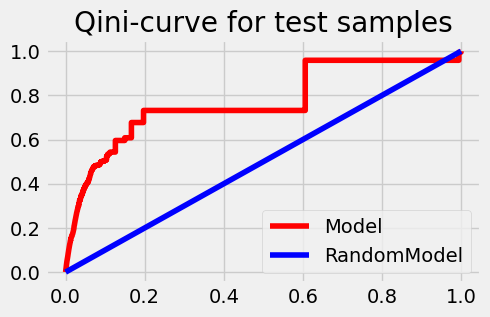

Qini score: 137479.505


In [29]:
# Посмотрим на скоры на трейне и валидации
qini_df(data_train, title="train")
qini_df(data_test, title="test")

> Вывод